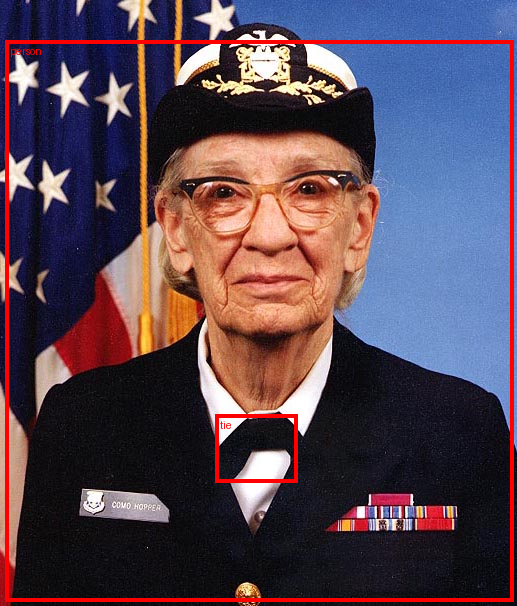

In [6]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

img = read_image("grace_hopper_517x606.jpg")


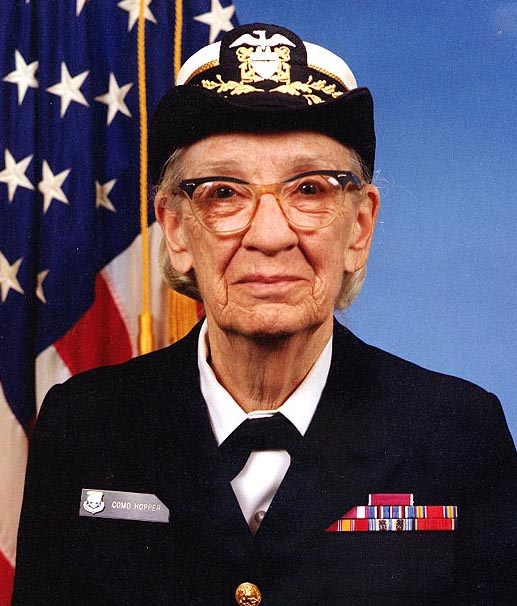

In [4]:
#read_image 말고 PIL 써보기 

from PIL import Image
Image_path = "grace_hopper_517x606.jpg"
Image.open(Image_path)

In [7]:
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT #세개의 결합임을 유추할 수 있음
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model

#backbone은 ResNet임을 알 수 있음

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [8]:
model.eval() #train할때는 안쓰고, evaluation 용으로 사용할 model임을 알려주는거임 

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

In [10]:
# Step 3: Apply inference preprocessing transforms

batch = [preprocess(img)]
batch[0].shape

torch.Size([3, 606, 517])

In [11]:
# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
prediction

{'boxes': tensor([[  5.0608,  40.3002, 513.7202, 601.9224],
         [215.8641, 414.0178, 297.2356, 482.0081]], grad_fn=<StackBackward0>),
 'labels': tensor([ 1, 32]),
 'scores': tensor([0.9990, 0.9716], grad_fn=<IndexBackward0>)}

In [13]:
weights.meta["categories"]

['__background__',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'N/A',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'N/A',
 'backpack',
 'umbrella',
 'N/A',
 'N/A',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'N/A',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'N/A',
 'dining table',
 'N/A',
 'N/A',
 'toilet',
 'N/A',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'N/A',
 'book',
 'clock',
 'vase',
 'scissors',
 'ted

In [14]:
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

In [15]:
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)

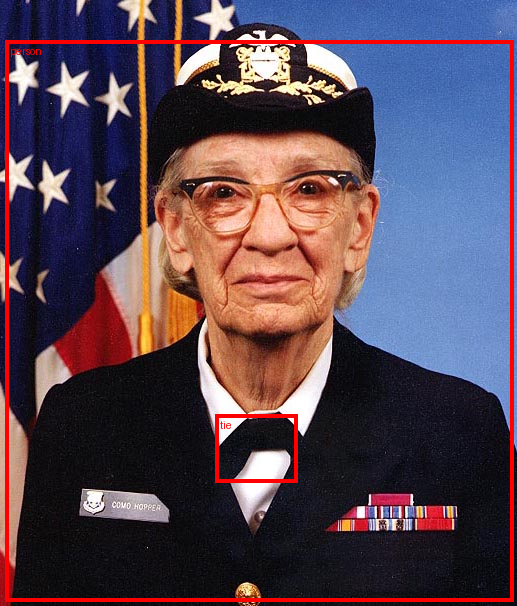

In [17]:
im = to_pil_image(box.detach())
im

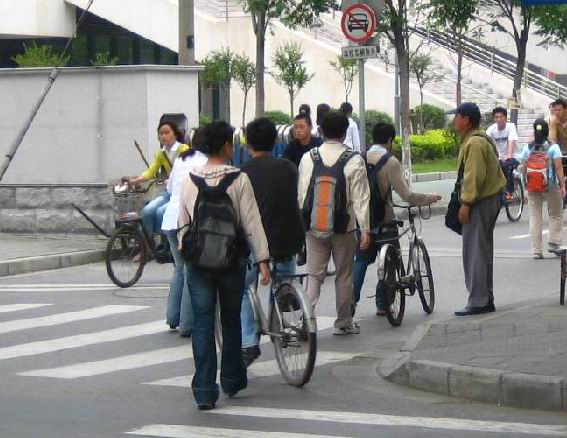

In [20]:
img_path = "data/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png"
image = Image.open(img_path)
image

In [21]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [23]:
import torchvision.transforms.v2 as v2

my_transform = v2.Compose([
    v2.ToTensor()
])

C:\Users\user\anaconda3\envs\torch-book\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [26]:
root = "data/PennFudanPed/PennFudanPed"
dataset = PennFudanDataset(root, my_transform)

In [32]:
import utils

In [34]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size =2, shuffle=True, collate_fn=utils.collate_fn)
for X_train, y_label in data_loader:
        print(X_train[0].shape)
        print(X_train[0].shape)
        print(y_label)

        break

torch.Size([3, 370, 500])
torch.Size([3, 370, 500])
({'boxes': BoundingBoxes([[ 81.,  22., 211., 357.],
               [ 42.,  38., 121., 345.],
               [205.,  37., 365., 325.]], format=BoundingBoxFormat.XYXY, canvas_size=[370, 500]), 'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([1, 1, 1]), 'image_id': 163, 'area': tensor([43550., 24253., 46080.]), 'isc